In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime

# Style for paper-quality
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 300

# Load (adjust path)
df = pd.read_csv('final_combined_dataset.csv')
df['date'] = pd.to_datetime(df['date'])

# Cast types for safety
df['injuries_status'] = df['injuries_status'].astype(int)
df['athlete_id'] = df['athlete_id'].astype(str)  # Ensure string for grouping

# Inspection
print("Dataset shape:", df.shape)
print("\nFirst few rows:\n", df.head())
print("\nColumn names:\n", df.columns.tolist())
print("\nMissing values:\n", df.isnull().sum())
print("\nSummary stats:\n", df.describe())
print("\nInjuries unique values:", df['injuries_status'].unique())

# Handle NaNs in _chg cols (forward-fill if trends, else 0)
chg_cols = [col for col in df.columns if col.endswith('_chg')]
df[chg_cols] = df.groupby('athlete_id')[chg_cols].fillna(method='ffill').fillna(0)

# Outlier removal (only for cols with variance >0)
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].std() > 0:  # Skip constants
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
print("Outliers removed for varying columns.")

Dataset shape: (3856, 103)

First few rows:
   athlete_id       date  injuries_status  game_workload  workload_7d  acwr  \
0    ATH0001 2024-01-01                0     245.054581   245.054581   1.0   
1    ATH0002 2024-01-02                0    1513.023725  1513.023725   1.0   
2    ATH0003 2024-01-03                0    1130.766374  1130.766374   1.0   
3    ATH0004 2024-01-04                0     829.387815   829.387815   1.0   
4    ATH0005 2024-01-05                0    2114.548016  2114.548016   1.0   

   rest_days_7d  sl._no.  sl._no._trend7  training_intensity_chg  ...  \
0           0.0   1428.5          1425.5                     0.0  ...   
1           0.0   1428.5          1425.5                     0.0  ...   
2           0.0   1428.5          1425.5                     0.0  ...   
3           0.0   1428.5          1425.5                     0.0  ...   
4           0.0   1428.5          1425.5                     0.0  ...   

   reaction_time_sec_chg  recovery_time_hr_chg 

C:\Users\ABHISHEK SAXENA\AppData\Local\Temp\ipykernel_22748\2681376701.py:32: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  df[chg_cols] = df.groupby('athlete_id')[chg_cols].fillna(method='ffill').fillna(0)
C:\Users\ABHISHEK SAXENA\AppData\Local\Temp\ipykernel_22748\2681376701.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[chg_cols] = df.groupby('athlete_id')[chg_cols].fillna(method='ffill').fillna(0)


Outliers removed for varying columns.


In [8]:
# Remove outliers (e.g., workloads > 3 std devs; adjust thresholds)
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]

# Engineer features: Weekly workload average
df['week'] = df['date'].dt.isocalendar().week
weekly_workload = df.groupby(['athlete_id', 'week'])['game_workload'].mean().reset_index()

# Injury rate: Proportion injured
injury_rate = df.groupby('athlete_id')['injuries_status'].mean().reset_index()
print("Injury rates per athlete:\n", injury_rate)

Injury rates per athlete:
   athlete_id  injuries_status
0  athlete_0              0.0


In [9]:
# Weekly features
df['week'] = df['date'].dt.isocalendar().week
weekly_workload = df.groupby(['athlete_id', 'week'])['game_workload'].mean().reset_index()

# Injury rates (fixed print)
injury_rate = df.groupby('athlete_id')['injuries_status'].mean().reset_index()
print("Injury rates per athlete:\n", injury_rate.head(10))  # Top 10 for large data
if len(injury_rate) > 1:
    print(f"Average injury rate: {injury_rate['injuries_status'].mean():.3f}")
else:
    print("Only one athlete group found.")

Injury rates per athlete:
   athlete_id  injuries_status
0  athlete_0              0.0
Only one athlete group found.


In [14]:
df['game_workload'].nunique(), df['game_workload'].unique()[:10]


(1, array([0.]))

In [15]:
df.groupby('athlete_id')['game_workload'].std().describe()


count    1.0
mean     0.0
std      NaN
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: game_workload, dtype: float64

Game workload describe:
 count    1851.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: game_workload, dtype: float64
Sample per athlete:
             mean  std
athlete_id           
athlete_0    0.0  0.0


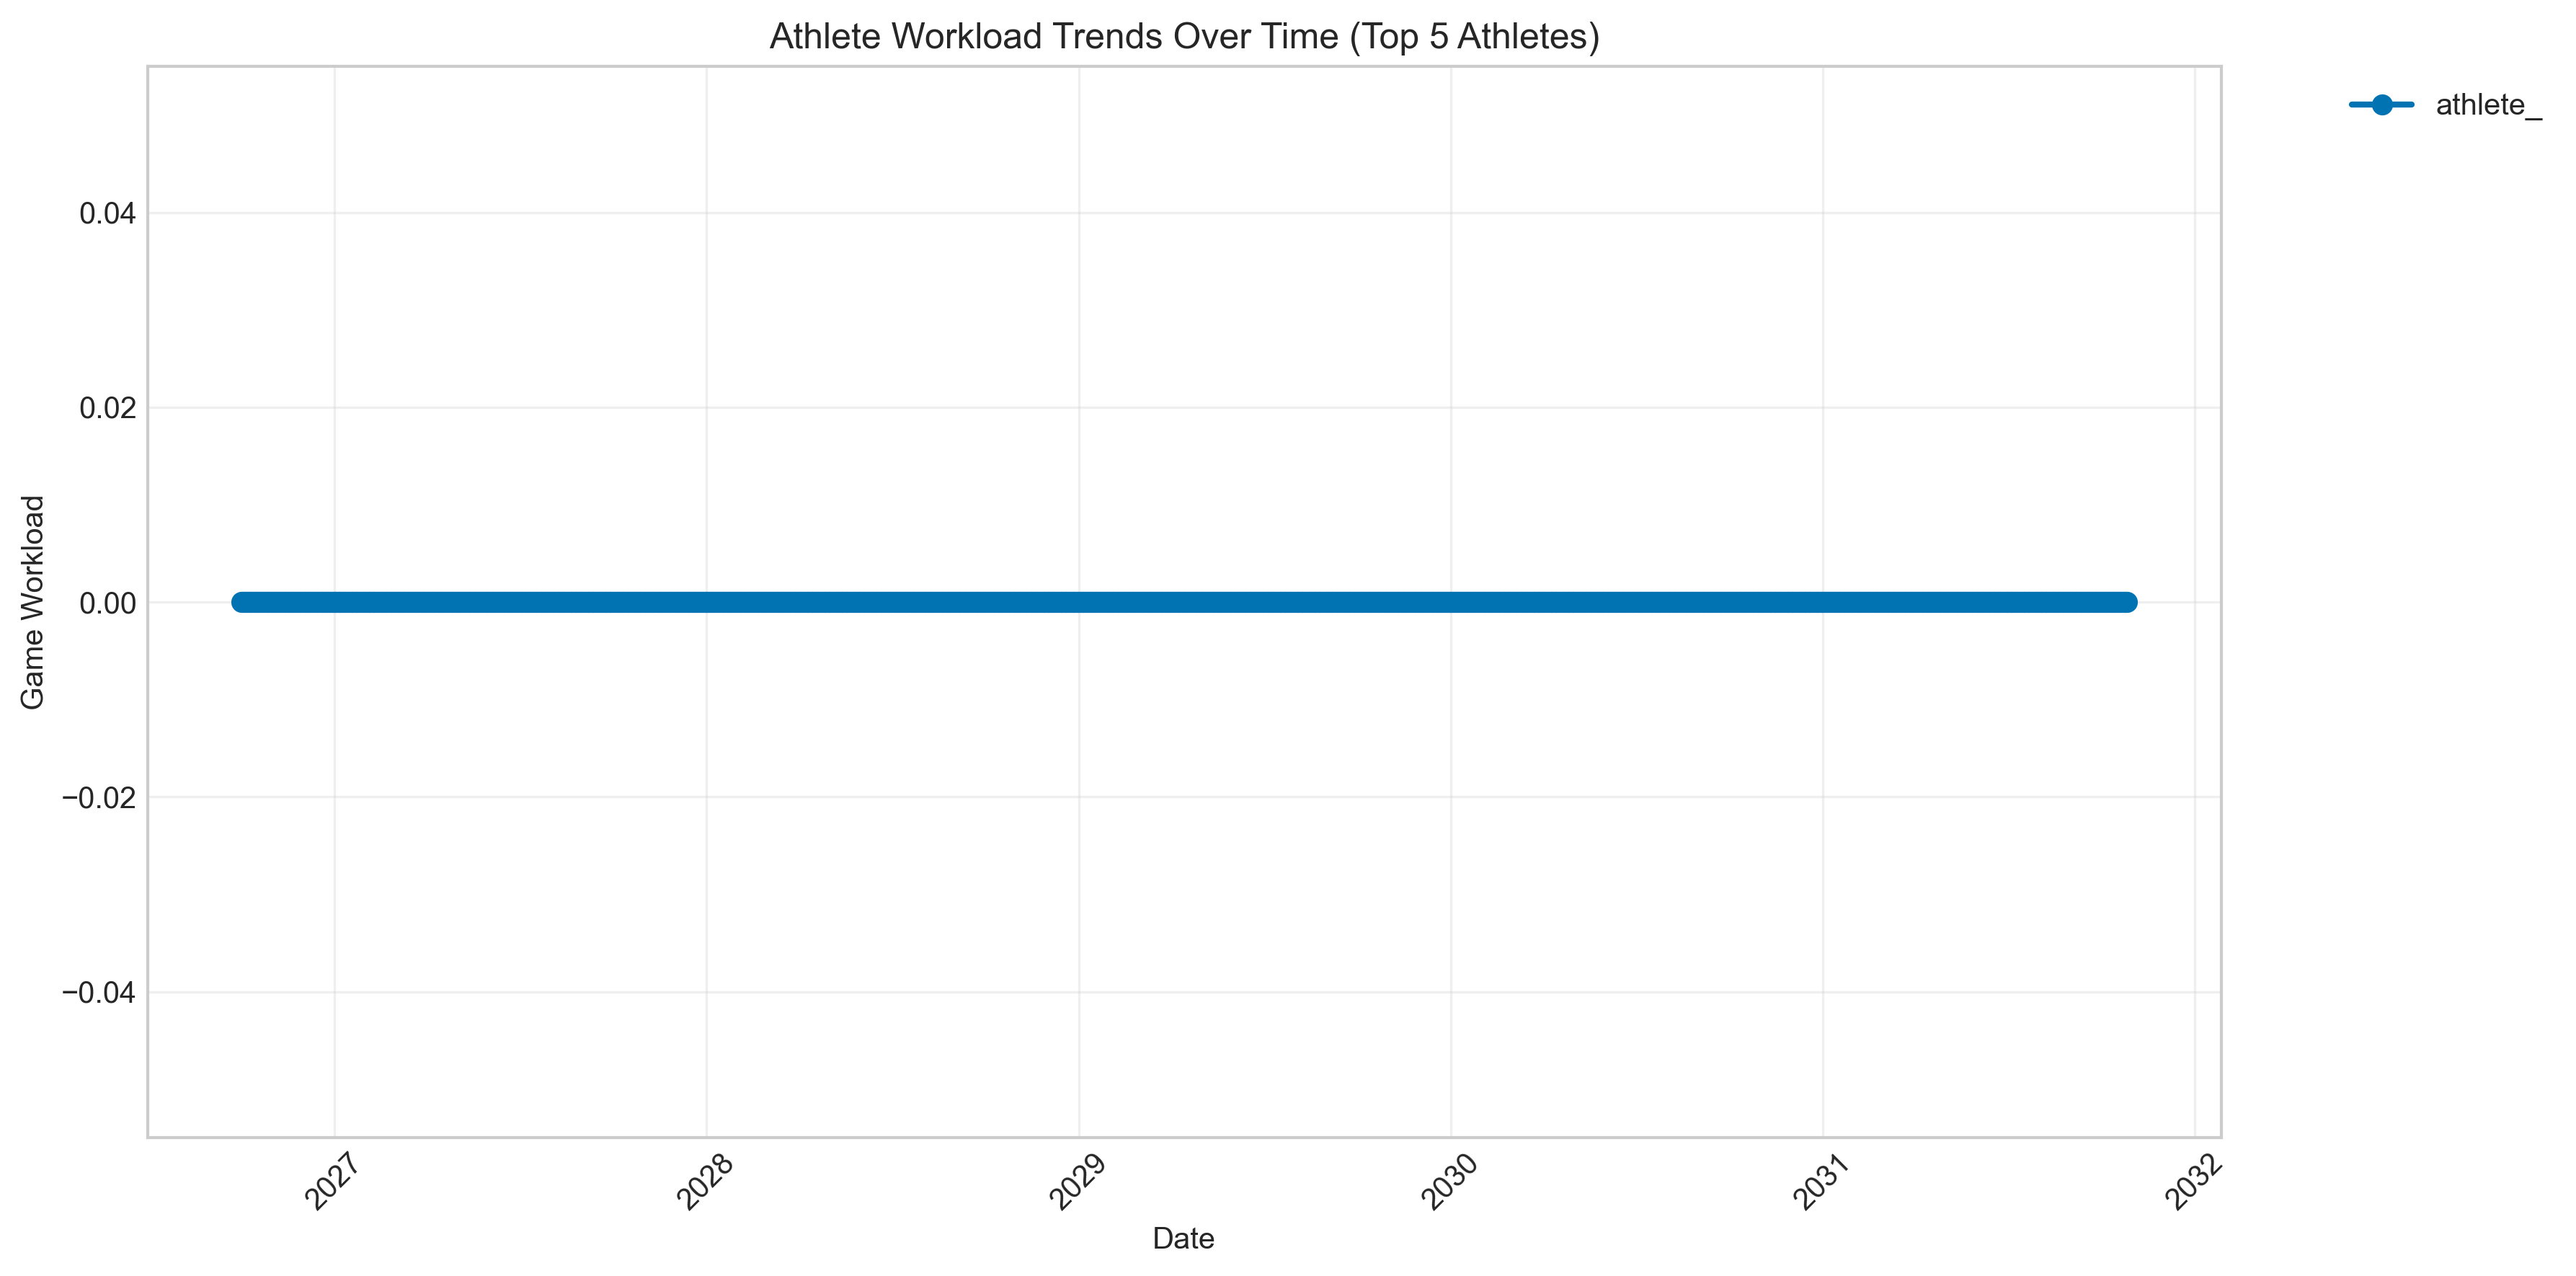

In [10]:
# Diagnostic: Check workload values
print("Game workload describe:\n", df['game_workload'].describe())
print("Sample per athlete:\n", df.groupby('athlete_id')['game_workload'].agg(['mean', 'std']).head())

fig, ax = plt.subplots(figsize=(12, 6))
unique_athletes = df['athlete_id'].unique()[:5]  # Limit to 5 for clarity; adjust
for athlete in unique_athletes:
    athlete_data = df[df['athlete_id'] == athlete].sort_values('date')
    if len(athlete_data) > 1:  # Skip single-point athletes
        ax.plot(athlete_data['date'], athlete_data['game_workload'], 
                marker='o', label=athlete[:8], linewidth=2)  # Truncate label
ax.set_xlabel('Date')
ax.set_ylabel('Game Workload')
ax.set_title('Athlete Workload Trends Over Time (Top 5 Athletes)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('workload_trends_fixed.png', dpi=300, bbox_inches='tight')
plt.show()

No injury variation (all 0s). Plotting overall distributions instead.


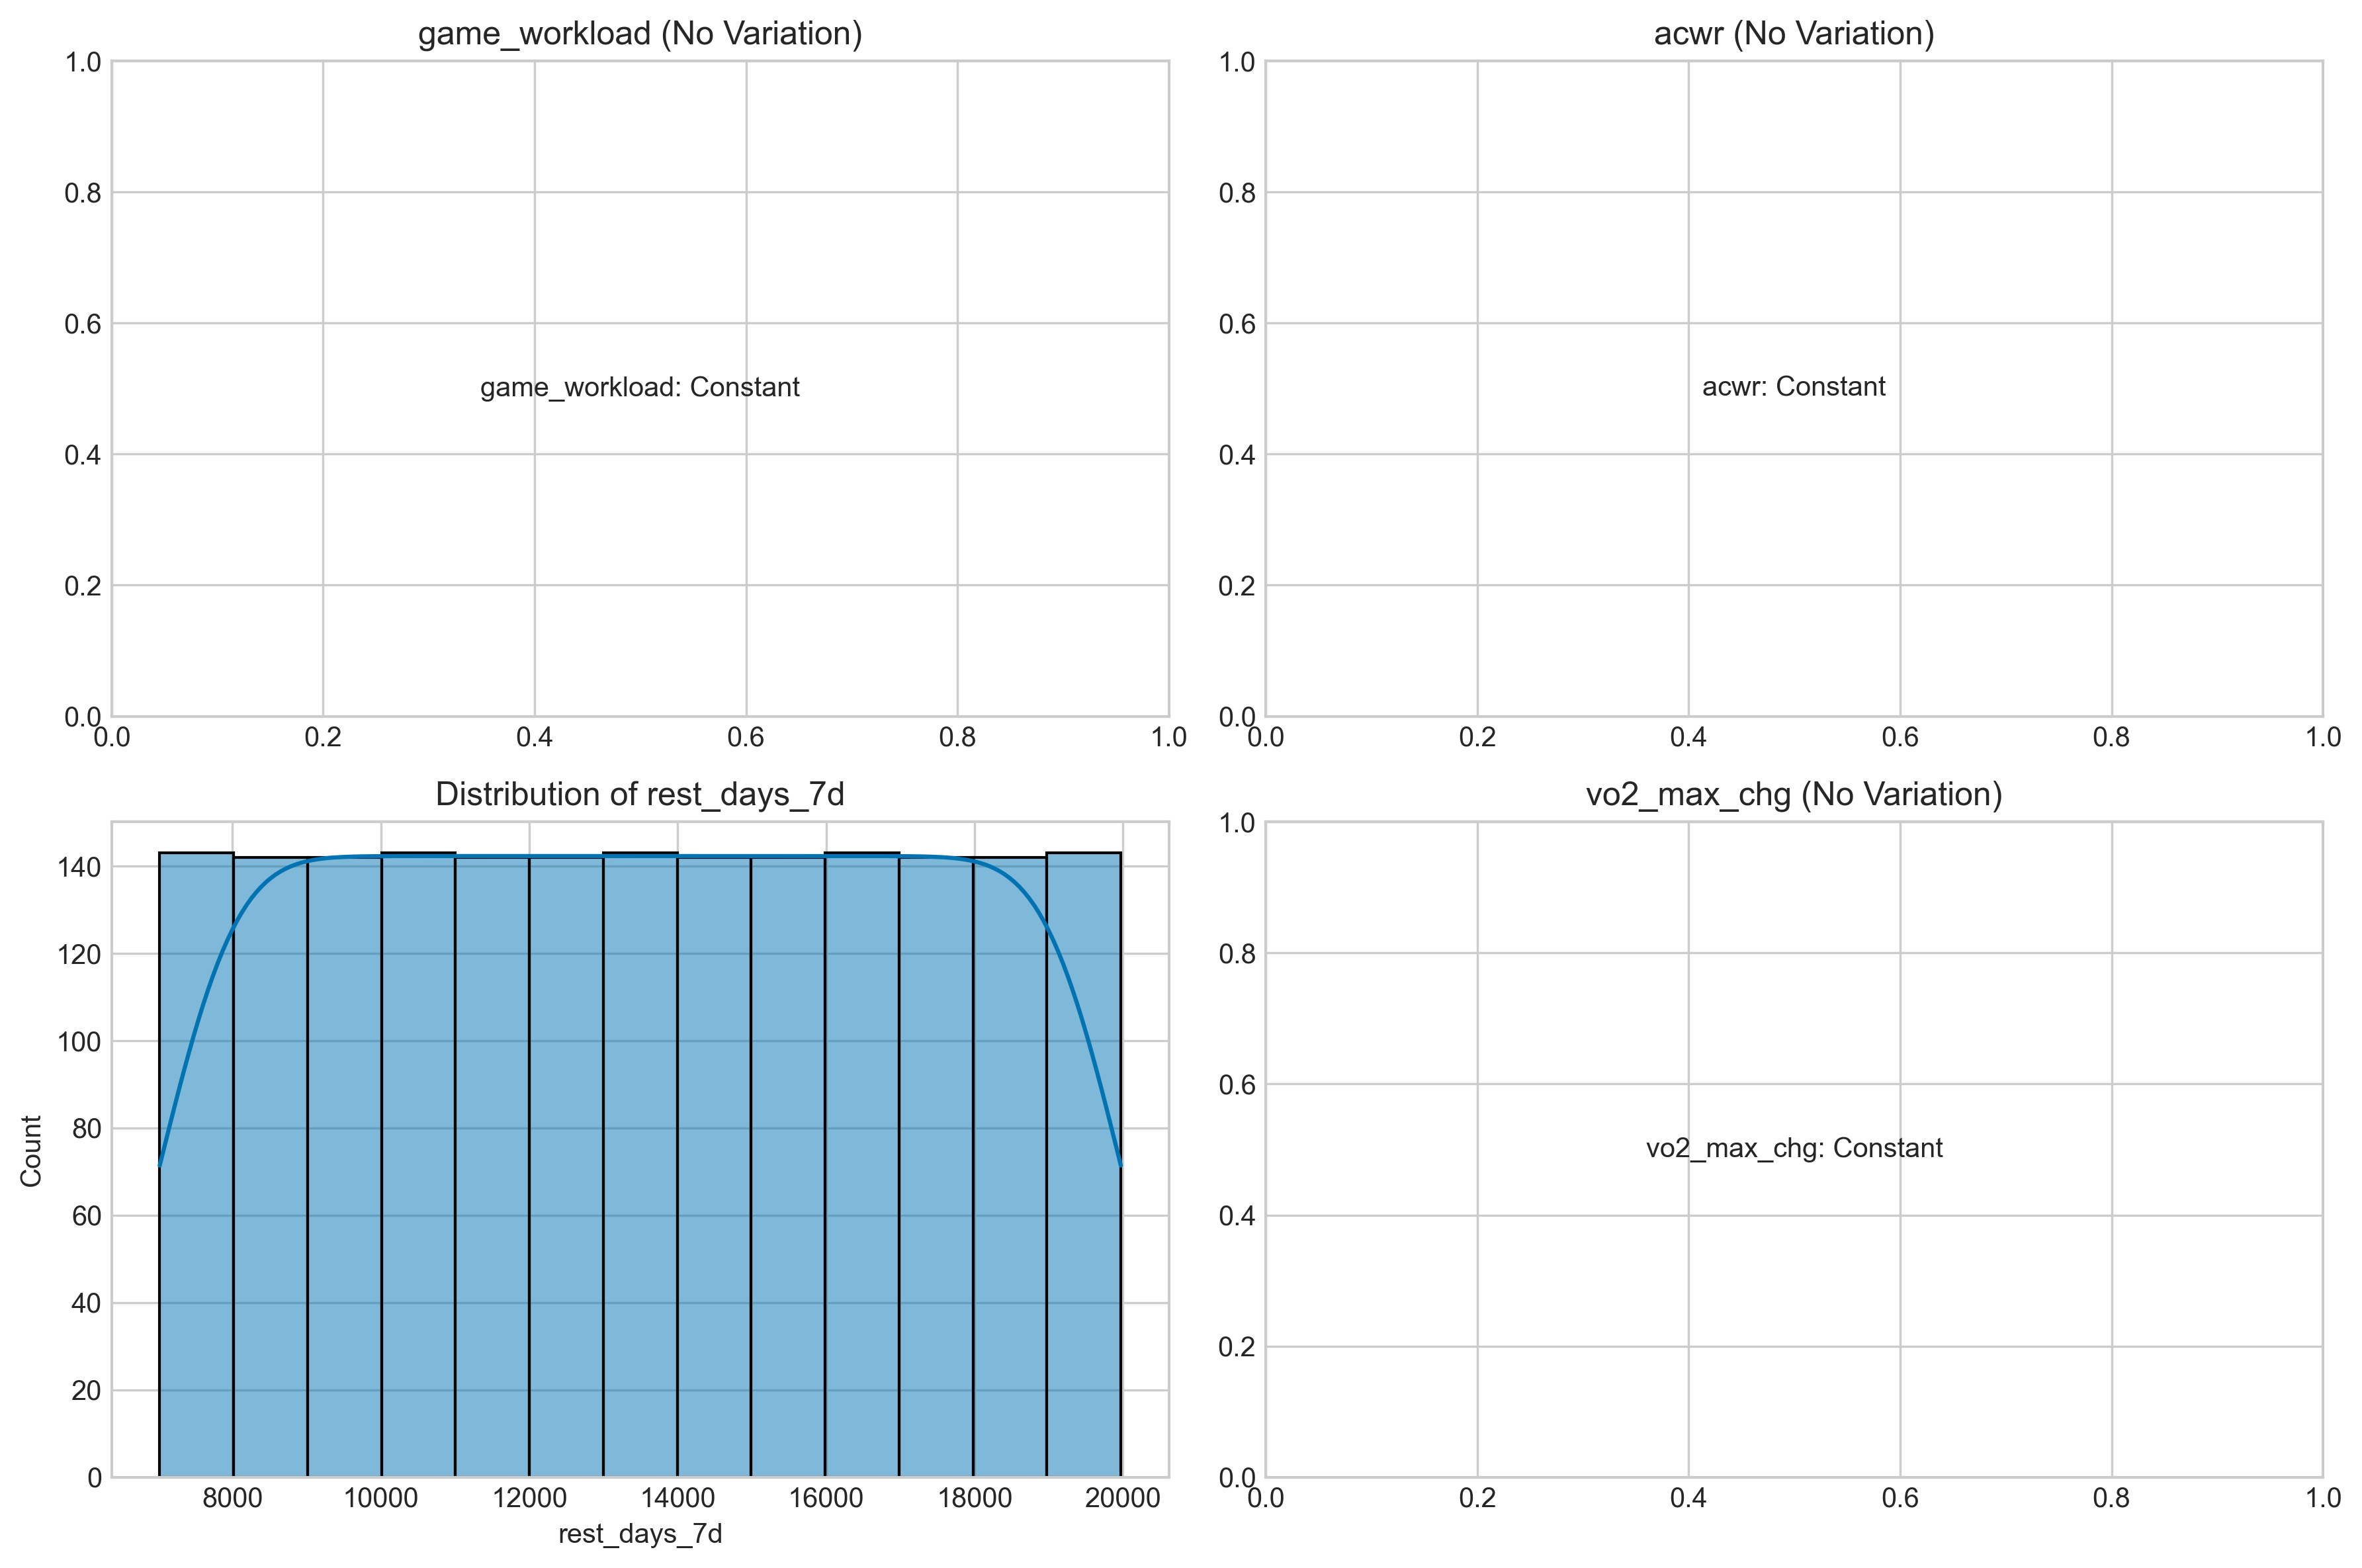

In [13]:
metrics = ['game_workload', 'acwr', 'rest_days_7d', 'vo2_max_chg']

if df['injuries_status'].nunique() > 1:
    # Comparative boxplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]

        if df[metric].std() > 0:
            sns.boxplot(data=df, x='injuries_status', y=metric, ax=ax)
            ax.set_title(f'{metric} by Injury Status')
            ax.set_xlabel('Injured (0 = No, 1 = Yes)')
        else:
            ax.text(0.5, 0.5, f'{metric}: Constant (std=0)',
                    ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{metric} (No Variation)')

    plt.tight_layout()
    plt.savefig('injury_comparisons_fixed.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("No injury variation (all 0s). Plotting overall distributions instead.")

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]

        if df[metric].std() > 0:
            sns.histplot(data=df, x=metric, kde=True, ax=ax)
            ax.set_title(f'Distribution of {metric}')
        else:
            ax.text(0.5, 0.5, f'{metric}: Constant',
                    ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{metric} (No Variation)')

    plt.tight_layout()
    plt.savefig('distributions_no_injury.png', dpi=300, bbox_inches='tight')
    plt.show()
